In [5]:
import os
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from scipy import ndimage
import pywt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [6]:
# Utils

# Importer une image
def import_image(filename):
    image = ski.io.imread(filename)
    return np.array(image)

# Afficher une image
def display_image(image, title):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [21]:
def apply_wavelet_transform(image, wavelet='haar', level=2):
    coeffs = []
    for channel in range(3):  # Appliquer la transformée sur chaque canal (R, G, B)
        coeffs.append(pywt.wavedec2(image[:, :, channel], wavelet, level=level))
    return coeffs

def normalize_coeffs(coeff):
    coeff_min, coeff_max = coeff.min(), coeff.max()
    coeff_normalized = 255 * (coeff - coeff_min) / (coeff_max - coeff_min)
    return coeff_normalized.astype(np.uint8)

def apply_wavelet_thresholding(coeffs, threshold=30):
    thresholded_coeffs = []
    for channel_coeffs in coeffs:
        channel_thresholded = []
        for i, coeff in enumerate(channel_coeffs):
            if i == 0:  # Coefficients d'approximation
                channel_thresholded.append(coeff)
            else:
                # Appliquer le seuillage sur les coefficients de détail
                thresholded_detail = tuple(pywt.threshold(c, threshold, mode='soft') for c in coeff)
                channel_thresholded.append(thresholded_detail)
        thresholded_coeffs.append(channel_thresholded)
    return thresholded_coeffs

def apply_inverse_wavelet_transform(coeffs, wavelet='haar'):
    denoised_channels = []
    for channel_coeffs in coeffs:
        denoised_channel = pywt.waverec2(channel_coeffs, wavelet)
        denoised_channels.append(np.clip(denoised_channel, 0, 255))
    # Recomposer une image couleur à partir des trois canaux
    return np.stack(denoised_channels, axis=-1).astype(np.uint8)

def wavelet_denoising(image, wavelet='haar', threshold=30, level=2):
    coeffs_noised = apply_wavelet_transform(image, wavelet=wavelet, level=level)
    coeffs_denoised = apply_wavelet_thresholding(coeffs_noised, threshold=threshold)
    return apply_inverse_wavelet_transform(coeffs_denoised, wavelet=wavelet)

In [20]:
# --- Fonction de test ---
def test_wavelet_denoising(image_path):
    # Charger l'image
    image = import_image(image_path)
    display_image(image, 'Image originale')

    image_noised = ski.util.random_noise(image, mode='gaussian', mean=0, var=0.01) * 255
    image_noised = image_noised.astype(np.uint8)
    display_image(image_noised, 'Image bruitée')

    psnr_noised = psnr(image, image_noised)
    print(f"PSNR entre l'image originale et l'image bruitée : {psnr_noised:.2f} dB")

    threshold = 30
    denoised_image = wavelet_denoising(image_noised, threshold=threshold)

    display_image(denoised_image, 'Image débruitée')
    ski.io.imsave("results/denoised_color.pgm", denoised_image)

    psnr_denoised = psnr(image, denoised_image)
    print(f"PSNR entre l'image originale et l'image débruitée : {psnr_denoised:.2f} dB")

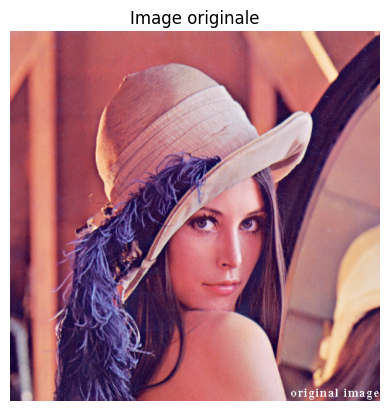

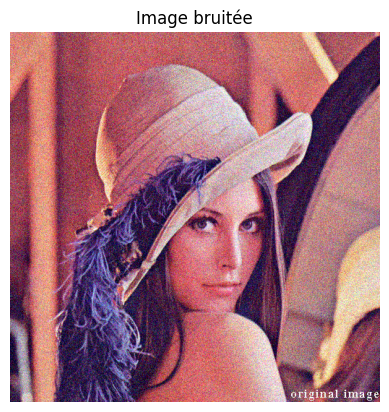

PSNR entre l'image originale et l'image bruitée : 20.20 dB


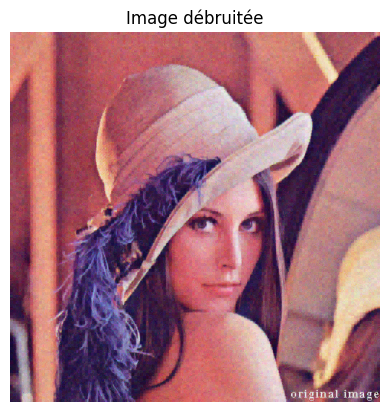

PSNR entre l'image originale et l'image débruitée : 25.89 dB


In [19]:
test_wavelet_denoising("lena.ppm")